### Climate skill at 1&deg;: annual- and global-mean time series

In [1]:
from collections import namedtuple
from string import ascii_lowercase

import xarray as xr
from matplotlib import pyplot as plt
import matplotlib as mpl

from utils import get_beaker_dataset_variables
from constants import INFERENCE_COMPARISON_1DEG

In [2]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
mpl.rc('font', size=8)

In [3]:
EvalVar = namedtuple("EvalVar", ("name", "long_name", "units"))

EVAL_VARS = [
    EvalVar("TMP2m", "2-meter air temperature", "K"),
    EvalVar("total_water_path", "total water path", "mm"),
]
ADDITIONAL_VARS = ['surface_temperature']
DS_VARS = [var.name for var in EVAL_VARS] + ADDITIONAL_VARS

In [4]:
datasets = []
for duration_name, duration_runs in INFERENCE_COMPARISON_1DEG.items():
    for group_name, group_runs in duration_runs.items():
        if isinstance(group_runs, dict):
            for ic_name, ic_run in group_runs.items():
                full_key = '/'.join([duration_name, group_name, ic_name])
                print(f"Getting run: {full_key=}")
                ic_dataset = get_beaker_dataset_variables(ic_run, 'annual_diagnostics.nc', DS_VARS)
                datasets.append(
                    ic_dataset
                    .expand_dims({'duration': [duration_name], 'group': [group_name], 'IC': [ic_name]})
                )
        else:
            full_key = '/'.join([duration_name, group_name])
            print(f"Getting run: {full_key=}")
            source_dataset = get_beaker_dataset_variables(group_runs, 'annual_diagnostics.nc', DS_VARS)
            datasets.append(
                source_dataset
                .expand_dims({'duration': [duration_name], 'group': [group_name]})
            )
annual_mean_ds = xr.merge(datasets).squeeze()

Downloading ⠦ 0:00:00 92.5 MB/s 30.7 kB

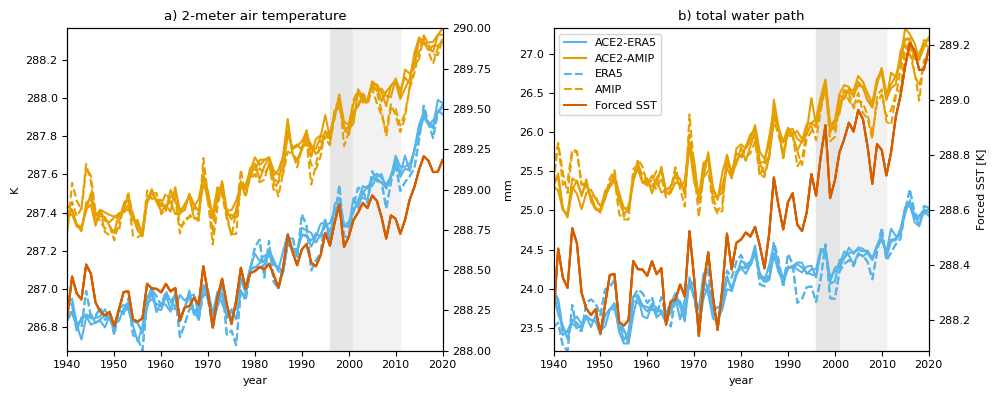

In [5]:
fillcolor1 = [0.9, 0.9, 0.9]
fillcolor2 = [0.95, 0.95, 0.95]

fig, axes = plt.subplots(1, len(EVAL_VARS), sharex='row', sharey='col')
axes = axes.squeeze()
for ax, var, letter in zip(axes, EVAL_VARS, ascii_lowercase):
    # highlight held-out periods
    ymin, ymax = annual_mean_ds[var.name].min(), annual_mean_ds[var.name].max()
    ax.fill_between([1996, 2001], [ymin, ymin], [ymax, ymax], color=fillcolor1)
    ax.fill_between([2001, 2011], [ymin, ymin], [ymax, ymax], color=fillcolor2)
    # time series
    hae = annual_mean_ds.sel(source='prediction', duration='81yr', group='ERA5-ACEv2')[var.name].plot(
        ax=ax, hue='IC', color=colors[0], add_legend=False
    )
    has = annual_mean_ds.sel(source='prediction', duration='81yr', group='SHiELD-AMIP-ACEv2')[var.name].plot(
        ax=ax, hue='IC', color=colors[1], label='SHiELD-AMIP-ACEv2', add_legend=False
    )
    he = annual_mean_ds.sel(source='target', duration='81yr', group='SHiELD-AMIP-vs.-ERA5')[var.name].plot(
        ax=ax, hue='IC', color=colors[0], ls='--', label='ERA5', add_legend=False
    )
    ha = annual_mean_ds.sel(source='prediction', duration='81yr', group='SHiELD-AMIP-vs.-ERA5')[var.name].plot(
        ax=ax, hue='IC', color=colors[1], ls='--', label='SHiELD-AMIP', add_legend=False
    )
    ax2 = ax.twinx()
    hs = annual_mean_ds.sel(source='target', duration='81yr', group='SHiELD-AMIP-ACEv2').surface_temperature.plot(
        ax=ax2, hue='IC', color=colors[4], label='SST', add_legend=False
    )
    ax2.set_title(None)
    if ax == axes[-1]:
        ax2.set_ylabel('Forced SST [K]')
    else:
        ax2.set_ylabel(None)
        ax2.set_ylim([288, 290])
    ax.set_ylim([ymin, ymax])
    ax.set_xlim([1940, 2020])
    ax.set_ylabel(var.units)
    ax.set_title(f"{letter}) {var.long_name}")
axes[-1].legend(
    [hae[0], has[0], he[0], ha[0], hs[0]],
    ['ACE2-ERA5', 'ACE2-AMIP', 'ERA5', 'AMIP', 'Forced SST']
)
fig.set_size_inches([10, 4])
fig.tight_layout()
fig.savefig('annual_mean_series.png', bbox_inches='tight', facecolor='w')